In [ ]:
from google.colab import files
uploaded = files.upload()

Saving data_unstacked.csv to data_unstacked.csv


In [ ]:
import numpy as np
import pandas as pd
import io

In [ ]:
df = pd.read_csv(io.BytesIO(uploaded['data_unstacked.csv']))

In [ ]:
df.head()

,FILENAME,SPEAKER,TURN_NUMBER,TURN_TEXT,ANNOTATOR,BATCH,CONV_ID,ROLE,PT_ID,PT_SEX,PRIMARYMDID,MDID,HCPID,HCPID2,PTSITE,PTRANDGRP,CONVNUM,FUNCTIONAL_STATUS,ILLNESS_UNDERSTANDING,SYMPTOMS
0,C5024_CLEAN,FACILITATOR,0,Conversation C5024.,ELISE,0,C5024,facilitator,1219.0,M,5020.0,5020.0,NaN,NaN,1.0,3.0,1.0,0,0,0
1,C5024_CLEAN,FACILITATOR,0,Conversation C5024.,KATE,0,C5024,facilitator,1219.0,M,5020.0,5020.0,NaN,NaN,1.0,3.0,1.0,0,0,0
2,C5024_CLEAN,FACILITATOR,0,Conversation C5024.,NICOLE,0,C5024,facilitator,1219.0,M,5020.0,5020.0,NaN,NaN,1.0,3.0,1.0,0,0,0
3,C5024_CLEAN,ONCOLOGIST (MALE),1,Hey.,ELISE,0,C5024,clinician,1219.0,M,5020.0,5020.0,NaN,NaN,1.0,3.0,1.0,0,0,0
4,C5024_CLEAN,ONCOLOGIST (MALE),1,Hey.,KATE,0,C5024,clinician,1219.0,M,5020.0,5020.0,NaN,NaN,1.0,3.0,1.0,0,0,0


In [ ]:
# bag of words - taken from 6.871 PS1
import re
import nltk
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 

In [ ]:
# note: this function was inspired by the following link's preprocessing function: 
# https://kavita-ganesan.com/how-to-use-countvectorizer/#.Yg0SrujMJdh
def my_cool_preprocessor(text):
    text=text.lower() # convert to all lower case
    text=re.sub("\\W"," ",text) # remove special chars
    text=re.sub("\\s+(in|the|all|for|and|on)\\s+"," _connector_ ",text) # normalize certain words
    text = re.sub(r'\d+', '', text) # remove digits
    return text

corpus = df["TURN_TEXT"]
count_vec = CountVectorizer(max_features = 100, stop_words='english', preprocessor = my_cool_preprocessor)
count_data = count_vec.fit_transform(corpus)
cv_data = pd.DataFrame(count_data.toarray(), columns = count_vec.get_feature_names_out())


In [ ]:
df_combined = pd.concat([df, cv_data], axis=1)

In [ ]:
df_combined.head()

,FILENAME,SPEAKER,TURN_NUMBER,TURN_TEXT,ANNOTATOR,BATCH,CONV_ID,ROLE,PT_ID,PT_SEX,...,ve,want,way,week,weeks,went,work,yeah,yep,yes
0,C5024_CLEAN,FACILITATOR,0,Conversation C5024.,ELISE,0,C5024,facilitator,1219.0,M,...,0,0,0,0,0,0,0,0,0,0
1,C5024_CLEAN,FACILITATOR,0,Conversation C5024.,KATE,0,C5024,facilitator,1219.0,M,...,0,0,0,0,0,0,0,0,0,0
2,C5024_CLEAN,FACILITATOR,0,Conversation C5024.,NICOLE,0,C5024,facilitator,1219.0,M,...,0,0,0,0,0,0,0,0,0,0
3,C5024_CLEAN,ONCOLOGIST (MALE),1,Hey.,ELISE,0,C5024,clinician,1219.0,M,...,0,0,0,0,0,0,0,0,0,0
4,C5024_CLEAN,ONCOLOGIST (MALE),1,Hey.,KATE,0,C5024,clinician,1219.0,M,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#create subdatasets for train/val/test
df_train, df_valid, df_test = np.split(df_combined.sample(frac=1, random_state=42), 
                       [int(.6*len(df_combined)), int(.8*len(df_combined))])



In [ ]:
# train the logistic regression using the text features as features
feat_names_lab = list(df_combined)[20:]
X_df_train = df_train[feat_names_lab].values
y_df_train = df_train['SYMPTOMS'].values
print(X_df_train.shape)
print(y_df_train.shape)

X_df_valid = df_valid[feat_names_lab].values
y_df_valid = df_valid['SYMPTOMS'].values
print(X_df_valid.shape)
print(y_df_valid.shape)

X_df_test = df_test[feat_names_lab].values
y_df_test = df_test['SYMPTOMS'].values
print(X_df_test.shape)
print(y_df_test.shape)

(69003, 100)
(69003,)
(23001, 100)
(23001,)
(23001, 100)
(23001,)


In [ ]:
# write a loop going through all C and penalty values, select the values with best validation accuracy (see chunk below)
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline

d = {'C': [0.1,0.25,0.5,1., 0.1,0.25,0.5,1.], 'penalty': ['l1', 'l1', 'l1', 'l1', 'l2', 'l2', 'l2', 'l2']}
d = pd.DataFrame(data=d)
for i in d.index:
  pipe = Pipeline([('norm', StandardScaler()), ('LR', LogisticRegression(C=d["C"][i], penalty=d["penalty"][i], solver='liblinear'))])
  pipe.fit(X_df_train, y_df_train)
  ypred = pipe.predict(X_df_valid)
  #accuracy
  d.loc[i, "validation_acc"] = accuracy_score(y_df_valid, ypred)

max_validation_acc = d["validation_acc"].max()
C_best = d[d["validation_acc"] == max_validation_acc ][["C"]].squeeze()
penalty_best = d[d["validation_acc"] == max_validation_acc ][["penalty"]].squeeze()

#on test data
ypred2 = pipe.predict(X_df_test)
acc = accuracy_score(y_df_test, ypred2)
print(f'test accuracy: {acc}')

test accuracy: 0.8688752662927699


In [ ]:
d

,C,penalty,validation_acc
0,0.10,l1,0.873571
1,0.25,l1,0.873658
2,0.50,l1,0.873745
3,1.00,l1,0.873745
4,0.10,l2,0.873745
5,0.25,l2,0.873745
6,0.50,l2,0.873745
7,1.00,l2,0.873745


# Tiana's Part 

## Evaluation of the LR Model

In [ ]:
#extract model from pipeline
lr = pipe['LR']

Here I evaluate the model from prediction imbalance, AUC, and sensitivity

1. The LR model only predicts 0 or 3. Possibly due to the fact that class 1 and class 2 consists of only a tiny proportion of the data to begin with. 

2. Weighted multiclass AUC is 0.693. Out of the 4 classes, class 0 and 3 have individual AUC (OVR) of 0.73 while the other two classes only have AUC 0.63 and 0.68.

3. Sensitivity for class 3 is at 2%. Out of 2460 cases with class 3, the model identified 54 cases correctly.

In [ ]:
#count the number of times each class appeared in predictions
from collections import Counter
Counter(lr.predict(X_df_test))

Counter({0: 22872, 3: 129})

In [ ]:
#count the number of times each class appeared in actual dataset 
Counter(y_df_test)

Counter({0: 19679, 1: 337, 2: 525, 3: 2460})

In [ ]:
#weighted average of auc across four classes
from sklearn.metrics import roc_auc_score
roc_auc_score(y_df_test, lr.predict_proba(X_df_test), multi_class='ovr')

0.6929535430467888

In [ ]:
#get one-versus-rest auc score for each class
for label in [0,1,2,3]:
  y_bin = [1 if x == label else 0 for x in y_df_test]
  pred = lr.predict_proba(X_df_test)[:,label]
  auc = roc_auc_score(y_bin, pred)
  print(f"Class {label} has OVR AUC of {auc}")

Class 0 has OVR AUC of 0.7309213845495337
Class 1 has OVR AUC of 0.6274325169342666
Class 2 has OVR AUC of 0.6797498707616165
Class 3 has OVR AUC of 0.7337103999417386


In [ ]:
#sensitivity for class 3 
pred3 = np.array([1 if x == 3 else 0 for x in lr.predict(X_df_test)])
true3 = np.array([1 if x == 3 else 0 for x in y_df_test])

sum(pred3[true3 == 1])/sum(true3[true3 == 1])

0.02195121951219512

## Feature Importance of the LR Model

Unlike we conjectured, most of the words that have the highest influence on the probability of being class 3 are **NOT** directly describing the symptoms. Instead they tend to be more related to how patients express their feelings, i.e. "like", "feeling", "feel", "bad".

Also, the nature of bag-of-words made it hard to recover the contextual relationship between words used in a sentence. For instance, the model is sensitive to the word "feel", but it does not capture what the patient said after the word "feel", i.e. the actual symptom that we want to extract. 

In [ ]:
feature_importance = pd.DataFrame({
    'features': feat_names_lab,
    'coefs': lr.coef_[-1,:]
})

In [ ]:
feature_importance.sort_values(by = 'coefs', ascending = False).head(20)

,features,coefs
62,pain,0.569341
1,_connector_,0.224086
44,like,0.125166
24,feeling,0.120519
23,feel,0.115601
33,having,0.104779
45,little,0.088023
59,night,0.084602
8,cause,0.084436
18,does,0.076090


## Trying XGBoost 

In [ ]:
from sklearn.utils import class_weight
import xgboost as xgb

#do gridsearch to find best parameters for XGBoost 
def run_xgb(x_train, y_train, metric = 'roc_auc_ovr_weighted', max_depth = np.arange(2,6,2), learning_rate = [0.1], n_estimators = np.arange(100,350,50)):
    print('running gridsearch for xgb...')
    classes_weights = class_weight.compute_sample_weight(
                                class_weight='balanced',
                                y=y_train
                        )
    cv_folds = 3
    param_grid = {'max_depth': max_depth,
                  'learning_rate':learning_rate,
                  'n_estimators':n_estimators
                 }
    
    est = xgb.XGBClassifier(verbosity=1, objective = "multi:softmax", num_class = 4, sample_weight = classes_weights)

    #grid search
    gs = GridSearchCV(estimator = est, 
                            param_grid=param_grid, 
                            scoring = metric, 
                            cv= cv_folds, 
                            verbose=1)
    gs.fit(x_train, y_train, sample_weight = classes_weights)
    print(gs.best_params_)

    return gs.best_estimator_

In [ ]:
model = run_xgb(X_df_train, y_df_train)

running gridsearch for xgb...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 250}


### Evaluation of XGBoost (Using same metric as before)

We observe that the AUC remains pretty much the same, but prediction imbalance and sensitivity improved a lot compared to LR.

In [ ]:
from collections import Counter
#check model prediction breakdown 
Counter(model.predict(X_df_test))

Counter({0: 13842, 1: 2831, 2: 4267, 3: 2061})

In [ ]:
d = Counter(y_df_test)

In [ ]:
for key, value in d.items():
  print((key, value/len(y_df_test)))

(0, 0.8555714968914395)
(3, 0.10695187165775401)
(2, 0.022825094561106037)
(1, 0.014651536889700448)


In [ ]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [ ]:
#weighted average of auc across four classes
roc_auc_score(y_df_test, model.predict_proba(X_df_test), multi_class='ovr')

0.6906900391088917

In [ ]:
#get one-versus-rest auc score for each class
for label in [0,1,2,3]:
  y_bin = [1 if x == label else 0 for x in y_df_test]
  pred = model.predict_proba(X_df_test)[:,label]
  auc = roc_auc_score(y_bin, pred)
  print(f"Class {label} has OVR AUC of {auc}")

Class 0 has OVR AUC of 0.7543734983817176
Class 1 has OVR AUC of 0.5992790694873162
Class 2 has OVR AUC of 0.6609990762633582
Class 3 has OVR AUC of 0.7481085123031748


In [ ]:
#sensitivity for class 3 
pred3 = np.array([1 if x == 3 else 0 for x in model.predict(X_df_test)])
true3 = np.array([1 if x == 3 else 0 for x in y_df_test])

sum(pred3[true3 == 1])/sum(true3[true3 == 1])

0.3170731707317073

In [ ]:
#precision 
precision_score(true3, pred3)

0.3784570596797671

In [ ]:
#saving model
from google.colab import drive
drive.mount('/content/drive')

# import pickle
# pickle.dump(model, open('/content/drive/My Drive/xgb_6871_project.pkl', 'wb'))

Mounted at /content/drive


In [ ]:
import pickle
model = pickle.load(open('/content/drive/My Drive/xgb_6871_project.pkl', 'rb'))

### Shap Values

For XGBoost, analyzing feature importance is a bit tricky because the default feature importance attribute does not tell whether a word increases or decreases the probability of a certain prediction. Instead we can use SHAP plots.

In [ ]:
import shap 
explainer = shap.Explainer(model)

In [ ]:
shap_obj = explainer(X_df_train)

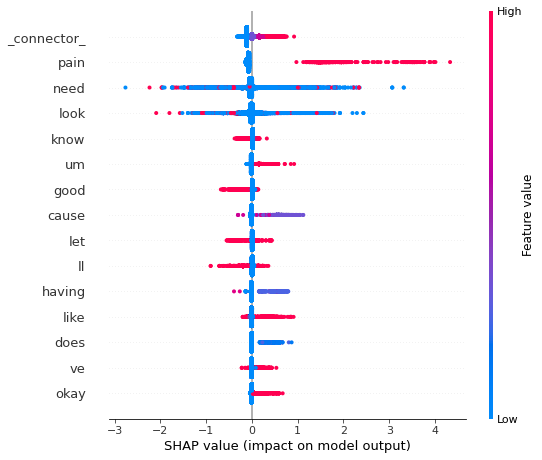

In [ ]:
#plot shap values for class 3
shap.summary_plot(shap_obj[:,:,-1], max_display=15, feature_names = feat_names_lab)

How to interpret SHAP plots: 
1. The y-axis indicates the variable name, in order of importance from top to 
bottom. The value next to them is the mean SHAP value.
2. On the x-axis is the SHAP value. Indicates how much is the change in log-odds per increment in the frequency of a particular word.

See this [link](https://blog.datascienceheroes.com/how-to-interpret-shap-values-in-r/) for more info. 

Like Logistic Regression, looking at feature importance by XGBoost is NOT helpful for symptom tagging. The only word directly describing symtom is "pain". 

I wonder if keeping connector words like "and"/"or" is necessary here as it seems to add noise to the datset (both models considered the connector words as important feature). 


## Next Step 

I think before we go on tuning the model, we should spend more time improving the vectorization. Some possible directions are
1. Removing words that are highly frequent throughout the corpus, i.e. the connector words and filler words. Methods include adjusting max_df/min_df and/or using TF-IDF.
2. Using not just unigram but also bigrams/trigrams
